In [36]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
import sys
import cv2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [37]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [38]:
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

In [39]:
def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input

    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    layer_output = layer_dict[activation_layer].output

    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

In [40]:
def modify_backprop(model, name):

    # tf.compat.v1.get_default_graph()
    # g = tf.get_default_graph()
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
        new_model.summary()
    return new_model

In [41]:

def deprocess_image(x):
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # K.image_dim_ordering()
    # keras.backend.image_data_format()
    # keras.backend.image_dim_ordering()
    if keras.backend.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [49]:
tf.compat.v1.disable_eager_execution()
def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 1000

    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    
    loss = K.sum(model.layers[-1].output)
    
    conv_output = [l for l in model.layers if l.name is layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)
  
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    
    cam = cv2.resize(cam, (224, 224))
    
    cam = np.maximum(cam, 0)
    
    heatmap = cam / np.max(cam)
    
    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    
    image = np.minimum(image, 255)

    
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    
    cam = np.float32(cam) + np.float32(image)
    
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap


preprocessed_input = load_image("/content/drive/My Drive/Project/Grad-CAM/images/cat_dog.jpg")


model = VGG16(weights='imagenet')


predictions = model.predict(preprocessed_input)
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

predicted_class = np.argmax(predictions)

cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")


Predicted class:
bull_mastiff (n02108422) with probability 0.41


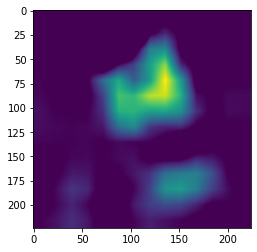

In [44]:
#Visualation heatmap image 
plt.imshow(heatmap)
plt.show()

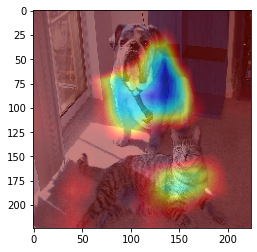

In [45]:
#Visualation cam image 
plt.imshow(cam)
plt.show()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

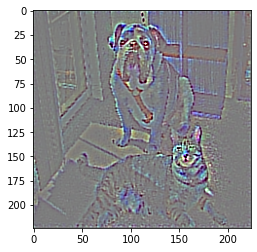

In [ ]:

register_gradient()

guided_model = modify_backprop(model, 'GuidedBackProp')

saliency_fn = compile_saliency_function(guided_model)

saliency = saliency_fn([preprocessed_input, 0])

gradcam = saliency[0] * heatmap[..., np.newaxis]


In [ ]:
#Visualation  image 
plt.imshow(deprocess_image(saliency[0]))
plt.show()

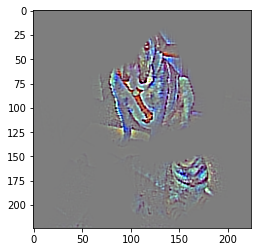

In [47]:
#Visualation  image 
plt.imshow(deprocess_image(gradcam))
plt.show()